In [1]:
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
import tensorflow as tf

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [4]:
# Load images
img_height = 256
img_width = 256
channels = 3
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    'Dataset/Flipkart/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    'Dataset/Flipkart/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 14664 images belonging to 1 classes.
Found 3666 images belonging to 1 classes.


In [ ]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Model Summary
autoencoder.summary()

In [ ]:
# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=50,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])

# Save model
autoencoder.save('models/image_autoencoder_2.h5')

In [ ]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
autoencoder.save('models/image_autoencoder_2')

In [5]:
autoencoder = tf.keras.models.load_model('models/image_autoencoder_2.')

In [6]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(256, 256))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (256, 256, 3))
  pred = array_to_img(pred)

  return raw_image, pred

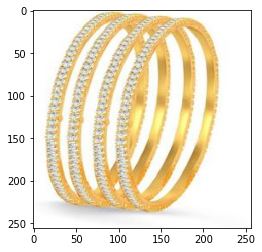

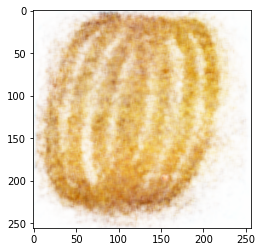

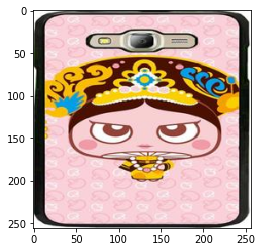

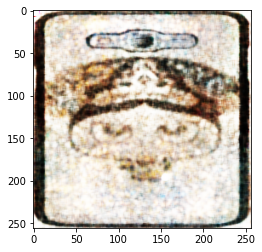

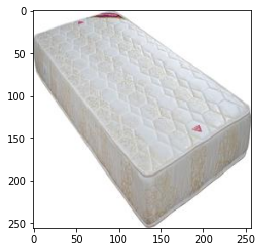

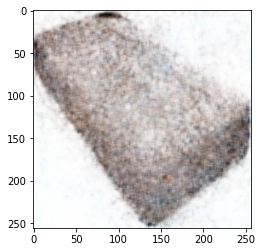

In [7]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

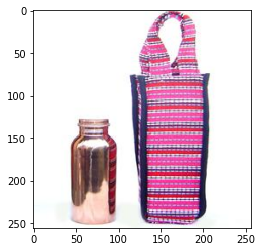

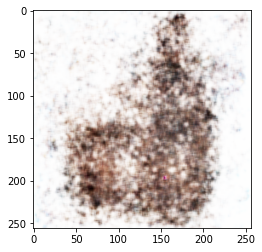

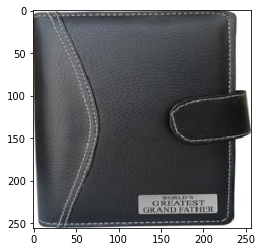

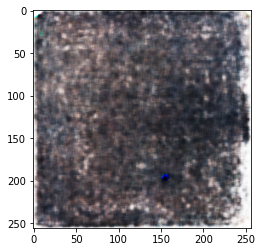

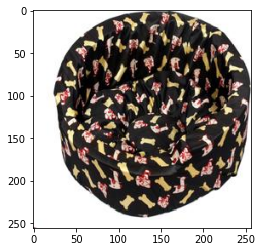

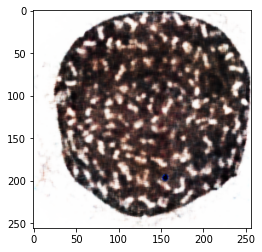

In [8]:
# Predict 3 images from validation set
val_imgs = validation_set.filepaths[0:3]

for i in val_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

In [9]:
# Create model with latent space layer
autoencoder = load_model('models/image_autoencoder_2', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [10]:
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('Dataset/Flipkart/images')))):
  try:
    img_name = os.listdir('Dataset/Flipkart/images')[i]
    img = load_img('Dataset/Flipkart/images/{}'.format(img_name), target_size = (256, 256))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

    # Export the embeddings
    if i in [1,10,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,13000,14000,15000,16000,17000,18000,19000]:
      embeddings = {'indices': indices, 'features': np.array(X)}

      pickle.dump(embeddings, open('Dataset/image_embeddings_2.pickle', 'wb'))

  except:
    print(img_name)

<ipython-input-10-c92da4540f7c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(os.listdir('Dataset/Flipkart/images')))):


  0%|          | 0/18330 [00:00<?, ?it/s]

In [11]:
# Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}

pickle.dump(embeddings, open('Dataset/image_embeddings_2.pickle', 'wb'))

In [12]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [13]:
# Load embeddings
embeddings = pickle.load(open('Dataset/image_embeddings_2.pickle', 'rb'))

# Load images metadata
metadata = pd.read_csv('Dataset/metadata.csv')

In [ ]:
embeddings

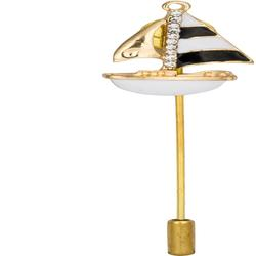

In [14]:
# Get image name
img_name = os.listdir('Dataset/Flipkart/images')[3]
img = load_img('Dataset/Flipkart/images/{}'.format(img_name), target_size=(256, 256))
img

Image Category: ["Jewellery >> Accessories >> Brooches >> Avaron Projekt Ship With Swarovski Brooch (White)"]


<ipython-input-15-c5dedae19ae1>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/18330 [00:00<?, ?it/s]

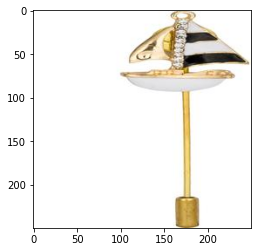

Image Category: ["Jewellery >> Accessories >> Brooches >> Avaron Projekt Ship With Swarovski Brooch (White)"]
Euclidean Distance: 759.8958129882812
Category Distance: 1.0


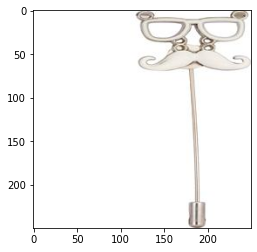

Image Category: ["Jewellery >> Accessories >> Brooches >> Avaron Projekt Spectacles And Moustache Brooch (..."]
Euclidean Distance: 23454.421875
Category Distance: 0.7446808510638298


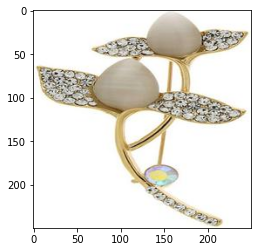

Image Category: ["Jewellery >> Accessories >> Brooches >> Anuradha Art Stylish Designer Brooch (Gold)"]
Euclidean Distance: 33828.87890625
Category Distance: 0.7111111111111111


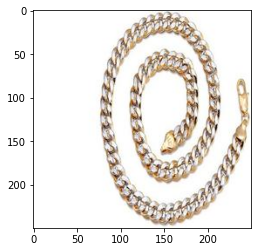

Image Category: ["Jewellery >> Necklaces & Chains >> Chains >> Magic 22K Yellow Gold Plated Brass Chain"]
Euclidean Distance: 33696.22265625
Category Distance: 0.4725274725274725


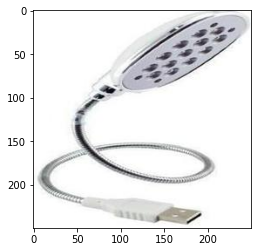

Image Category: ["Computers >> Laptop Accessories >> USB Gadgets >> ShopFloor.XYZ USB Gadgets"]
Euclidean Distance: 21601.3671875
Category Distance: 0.45348837209302323


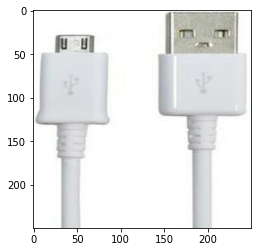

Image Category: ["Computers >> Laptop Accessories >> USB Gadgets >> MRK Communication USB Gadgets"]
Euclidean Distance: 30114.830078125
Category Distance: 0.4431818181818182


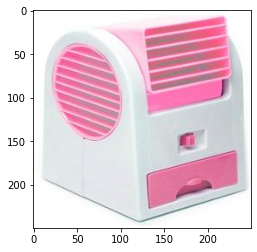

Image Category: ["Computers >> Laptop Accessories >> USB Gadgets >> Shadow Fax USB Gadgets"]
Euclidean Distance: 31491.486328125
Category Distance: 0.4378698224852071


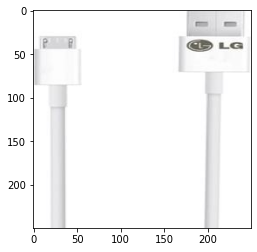

Image Category: ["Mobiles & Accessories >> Mobile Accessories >> Cables >> LG Cables"]
Euclidean Distance: 32866.3203125
Category Distance: 0.4171779141104294


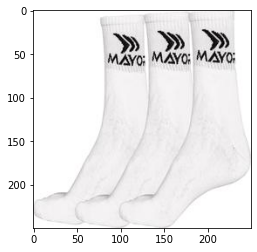

Image Category: ["Clothing >> Men's Clothing >> Accessories & Combo Sets >> Socks >> Mayor Socks >> Mayor Men's Ankle Length Socks"]
Euclidean Distance: 27929.697265625
Category Distance: 0.4019138755980861


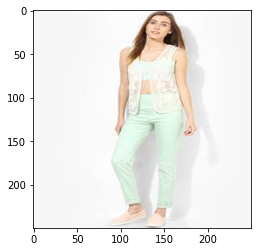

Image Category: ["Clothing >> Women's Clothing >> Formal Wear >> Waistcoats >> Vero Moda Waistcoats >> Vero Moda Self Design Women's Waistcoat"]
Euclidean Distance: 33200.80078125
Category Distance: 0.36199095022624433


In [15]:
# Calculate eucledian distance
img_similarity = []
cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 256
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))
img_cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
print('Image Category: {}'.format(img_cat))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity
  cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
  cat_sim = category_similarity(img_cat, cat)
  cat_similarity.append(cat_sim)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                            'category_similarity': cat_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

# Show 10 first similar images
for i in range(10):
  image = load_img('Dataset/Flipkart/images/{}'.format(imgs_result['img'].values[i]))
  category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]
  
  # Show image
  plt.imshow(image)
  plt.show()
  print('Image Category: {}'.format(category))
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))
  print('Category Distance: {}'.format(imgs_result['category_similarity'].values[i]))